In [1]:
import os
import sys
import aim

os.environ["CONFIG_PATHS"] = "../configs/self_play.yaml"
os.environ["CONFIG_OVERRIDES"] = 'game.moves_directory="../data/moves_10"'
sys.path.append("../src")

import numpy as np
import torch
from torch import nn
import glob
from tqdm import tqdm

from neural_net import NeuralNet
from training.load_games import load_games_new
from configuration import moves_data, config

Loaded config:  {"development": {"debug_mode": true, "profile": false, "runtime": 0, "display_logs_in_console": false, "output_directory": "data/2024-11-23_00-37-50-doublehandedness"}, "logging": {"save_interval": 3600, "mcts_report_fraction": 0, "ucb_report": false, "gpu_evaluation": true, "made_move": true}, "game": {"board_size": 10, "num_moves": 6233, "num_pieces": 21, "moves_directory": "../data/moves_10"}, "architecture": {"gameplay_processes": 6, "coroutines_per_process": 256, "game_flush_threshold": 200}, "training": {"run": true, "network_name": "default", "batch_size": 64, "policy_loss_weight": 0.158, "learning_rate": 0.001, "sample_window": 50000, "samples_per_generation": 10000, "sampling_ratio": 1.0, "minimum_window_size": 10000, "new_data_check_interval": 60}, "networks": {"default": {"main_body_channels": 64, "value_head_channels": 16, "value_head_flat_layer_width": 64, "policy_head_channels": 64, "residual_blocks": 8, "model_path": "", "model_directory": "data/2024-11-2

In [2]:
game_files = glob.glob("/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/games_we_didnt_train_on/*.npz")
gamedata = load_games_new(game_files, with_tqdm=True)

100%|██████████| 384/384 [00:06<00:00, 59.04it/s]


In [3]:
# Convert numpy arrays to torch tensors
boards_tensor = torch.from_numpy(gamedata["boards"]).to(dtype=torch.float, device="mps")
policies_tensor = torch.from_numpy(gamedata["policies"]).to(dtype=torch.float, device="mps")
values_tensor = torch.from_numpy(gamedata["values"]).to(dtype=torch.float, device="mps")

In [4]:
# Create TensorDataset
dataset = torch.utils.data.TensorDataset(boards_tensor, policies_tensor, values_tensor)

# Create DataLoader
batch_size = 64
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
)

In [5]:
selected_model_files = {
    204325: '/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/models/000204325.pt',
    403006: '/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/models/000403006.pt',
    808640: '/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/models/000808640.pt',
    1005949: '/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/models/001005949.pt',
    1110265: '/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/models/001110265.pt',
    1204743: '/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/models/001204743.pt',
    1309389: '/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/models/001309389.pt',
    1400050: '/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/models/001400050.pt',
    1500018: '/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/models/001500018.pt',
    1600050: '/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/models/001600050.pt',
    1700018: '/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/models/001700018.pt',
    1800050: '/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/models/001800050.pt',
    1900018: '/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/models/001900018.pt',
    2000050: '/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/models/002000050.pt',
    2100018: '/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/models/002100018.pt',
    2190002: '/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/models/002190002.pt'
}

In [7]:
losses = {}

for model_number, model_file in tqdm(selected_model_files.items()):
    model = NeuralNet(config()["networks"]["default"])
    model.load_state_dict(torch.load(model_file))
    model.to("mps")
    model.eval()

    losses[model_number] = {
        "total": 0,
        "value": 0,
        "policy": 0,
    }

    with torch.inference_mode():
        for batch_index, (boards, policies, values) in enumerate(dataloader):
            pred_values, pred_policy_logits = model(boards)
            value_loss = nn.CrossEntropyLoss()(
                pred_values,
                values,
            )
            policy_loss = config()["training"]["policy_loss_weight"] * nn.CrossEntropyLoss()(
                pred_policy_logits,
                policies,
            )
            loss = value_loss + policy_loss

            losses[model_number]["total"] += loss.item()
            losses[model_number]["value"] += value_loss.item()
            losses[model_number]["policy"] += policy_loss.item()

  0%|          | 0/16 [00:00<?, ?it/s]/var/folders/np/v76cnj490z525wk67wqh68dc0000gn/T/ipykernel_46186/1143046616.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.l

In [ ]:
len(gamedata["boards"])

In [8]:
print(losses)

{204325: {'total': 8514.827580928802, 'value': 5889.768158972263, 'policy': 2625.0594225525856}, 403006: {'total': 8035.668008208275, 'value': 5700.516443610191, 'policy': 2335.15156558156}, 808640: {'total': 7705.126314997673, 'value': 5598.385439753532, 'policy': 2106.7408755123615}, 1005949: {'total': 7776.261635065079, 'value': 5712.985044836998, 'policy': 2063.276590615511}, 1110265: {'total': 7590.196584582329, 'value': 5569.543862998486, 'policy': 2020.652722865343}, 1204743: {'total': 7569.5913944244385, 'value': 5548.90289580822, 'policy': 2020.6885027587414}, 1309389: {'total': 7363.224318861961, 'value': 5395.677765607834, 'policy': 1967.5465516149998}, 1400050: {'total': 7284.924566268921, 'value': 5362.978867173195, 'policy': 1921.9457000792027}, 1500018: {'total': 7338.363183736801, 'value': 5464.674338161945, 'policy': 1873.6888435184956}, 1600050: {'total': 7161.296206831932, 'value': 5305.244823813438, 'policy': 1856.0513855218887}, 1700018: {'total': 7152.021686792374

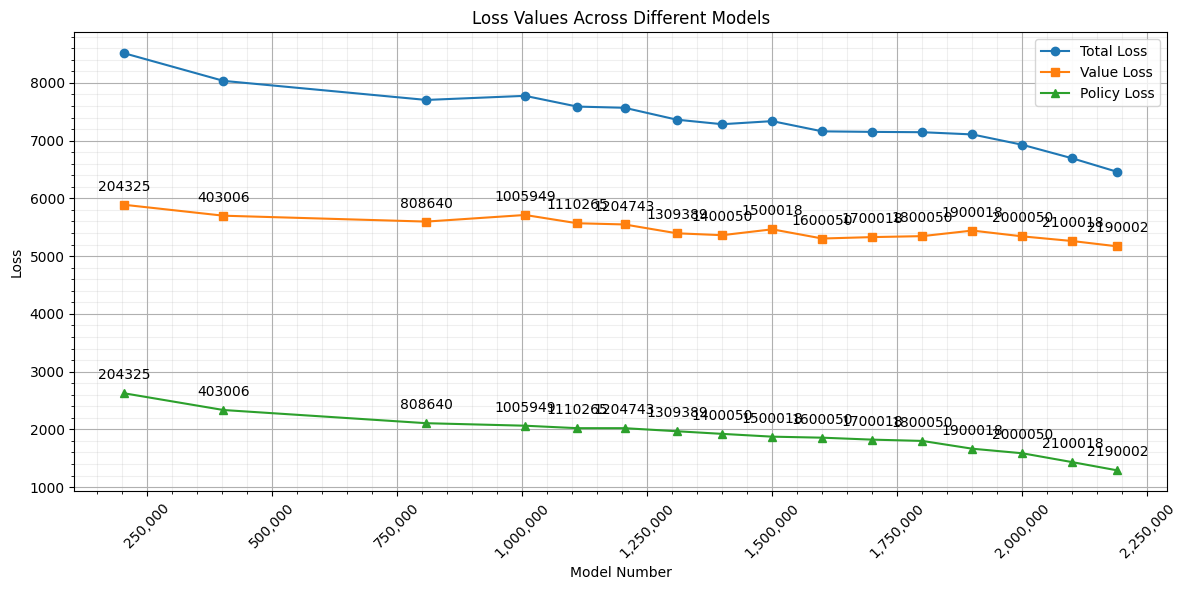

In [18]:
import matplotlib.pyplot as plt

model_numbers = sorted(losses.keys())
total_losses = [losses[m]["total"] for m in model_numbers]
value_losses = [losses[m]["value"] for m in model_numbers]
policy_losses = [losses[m]["policy"] for m in model_numbers]

plt.figure(figsize=(12, 6))
# plt.plot(model_numbers, total_losses, label='Total Loss', marker='o')
line = plt.plot(model_numbers, value_losses, label='Value Loss', marker='s')[0]

# Add labels for each point
for x, y in zip(model_numbers, value_losses):
    plt.annotate(str(x), 
                (x, y),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')

plt.plot(model_numbers, policy_losses, label='Policy Loss', marker='^')

for x, y in zip(model_numbers, policy_losses):
    plt.annotate(str(x), 
                (x, y),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')

plt.xlabel('Model Number')
plt.ylabel('Loss')
plt.title('Loss Values Across Different Models')
plt.legend()
plt.grid(True, which='both')
plt.minorticks_on()
plt.grid(True, which='minor', alpha=0.2)
plt.xticks(rotation=45)

# Format x-axis ticks to show full numbers without scientific notation
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
plt.show()

Among policy loss, we saw decrease every model. The "least decrease" was from 1.1e6 to 1.2e6. Big improvements were seen every generation from 1.8e6 onwards.

Among value loss, we saw more spiky behavior. Loss increased from 808640 to 1005949, and again from 1400050 to 1500018. It decreased sharply from 1500018 to 1600050, increased until 1900018, and dropped from there.